# Statcast Clustering

Objective: Experiment with various clustering techniques (Kmeans/DBscan) to cluster MLB pitch types. 

Data: Statcast data scraped into postgresql database on a weekly basis.

Clustering: Kmeans

Dimensionality Reduction: PCA

In [1]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


## Import Data

In [2]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [3]:
## fetch statcast data from postgresql database

def get_sql_data(engine):

    sql1 = '''
        SELECT *
        FROM statcast_2016
    '''
    sc_16 = pd.read_sql_query(sql1, engine)

    sql2 = '''
        SELECT *
        FROM statcast_2017
    '''
    sc_17 = pd.read_sql_query(sql2, engine)

    sql3 = '''
        SELECT *
        FROM statcast_2018
    '''

    sc_18 = pd.read_sql_query(sql3, engine)

    sql4 = '''
        SELECT *
        FROM statcast_2019
    '''

    sc_19 = pd.read_sql_query(sql4, engine)

    sql5 = '''
        SELECT *
        FROM statcast_2020
    '''

    sc_20 = pd.read_sql_query(sql5, engine)

    sql6 = '''
        SELECT *
        FROM statcast_2021
    '''

    sc_21 = pd.read_sql_query(sql6, engine)

    statcast = pd.concat([sc_16, sc_17, sc_18, sc_19, sc_20, sc_21])

    statcast['events']=statcast['events'].fillna('none')
    statcast['launch_speed']=statcast['launch_speed'].fillna(0)
    statcast['launch_angle']=statcast['launch_angle'].fillna(0)

    return statcast

In [4]:
statcast = get_sql_data(engine)

## Data Prep

In [5]:
# filter only relevant columns
cols = ['player_name', 'home_team', 'away_team', 'inning_topbot', 'p_throws', 'pitch_type', 'game_date', 'events', 'pitcher', 
         'batter', 'description', 'launch_speed', 'launch_angle', 'release_speed', 'release_pos_x', 
         'release_pos_y', 'release_pos_z', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z', 
         'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed',
         'pitch_name', 'spin_axis', 'woba_value', 'iso_value', 'delta_run_exp']

sc_cluster = statcast[cols]

# assign pitcher teams
def pitcher_team(row):

	if row['inning_topbot'] == 'Top':
		return row['home_team']
	
	if row['inning_topbot'] == 'Bot':
		return row['away_team']

sc_cluster['pitcher_team'] = sc_cluster.apply(pitcher_team, axis=1)

<ipython-input-5-408c3990a43b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_cluster['pitcher_team'] = sc_cluster.apply(pitcher_team, axis=1)


In [6]:
# Fastballs and Four Seam Fastballs are the same thing
# Group pitches into similar moving pitches: Fastballs, Moving Fastballs, Slider/Cutter, Curve and Off Speed

sc_cluster['pitch_type'] = sc_cluster['pitch_type'].replace(['FA'],'FF')

# categorize the pitches according to pitcher handedness and pitch type

conditions = [
    ((sc_cluster['p_throws'] == 'R') & (sc_cluster['pitch_type'] == 'FF')),
    ((sc_cluster['p_throws'] == 'R') & (sc_cluster['pitch_type'] == 'FT') | (sc_cluster['p_throws']=='R') & (sc_cluster['pitch_type']=='SI')),
    ((sc_cluster['p_throws'] == 'R') & (sc_cluster['pitch_type'] == 'SL') | (sc_cluster['p_throws']=='R') & (sc_cluster['pitch_type']=='FC')),
    ((sc_cluster['p_throws'] == 'R') & (sc_cluster['pitch_type'] == 'CU') | (sc_cluster['p_throws']=='R') & (sc_cluster['pitch_type']=='KC')),
    ((sc_cluster['p_throws'] == 'R') & (sc_cluster['pitch_type'] == 'CH') | (sc_cluster['p_throws']=='R') & (sc_cluster['pitch_type']=='FS')),
    ((sc_cluster['p_throws'] == 'L') & (sc_cluster['pitch_type'] == 'FF')),
    ((sc_cluster['p_throws'] == 'L') & (sc_cluster['pitch_type'] == 'FT') | (sc_cluster['p_throws']=='L') & (sc_cluster['pitch_type']=='SI')),
    ((sc_cluster['p_throws'] == 'L') & (sc_cluster['pitch_type'] == 'SL') | (sc_cluster['p_throws']=='L') & (sc_cluster['pitch_type']=='FC')),
    ((sc_cluster['p_throws'] == 'L') & (sc_cluster['pitch_type'] == 'CU') | (sc_cluster['p_throws']=='L') & (sc_cluster['pitch_type']=='KC')),
    ((sc_cluster['p_throws'] == 'L') & (sc_cluster['pitch_type'] == 'CH') | (sc_cluster['p_throws']=='L') & (sc_cluster['pitch_type']=='FS'))
    ]

values = ['rhp_ff', 'rhp_mf', 'rhp_slct', 'rhp_cukc', 'rhp_off', 'lhp_ff', 'lhp_mf', 'lhp_slct', 'lhp_cukc', 'lhp_off']

sc_cluster['cat'] = np.select(conditions, values)

<ipython-input-6-86efd213af1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_cluster['pitch_type'] = sc_cluster['pitch_type'].replace(['FA'],'FF')
<ipython-input-6-86efd213af1d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_cluster['cat'] = np.select(conditions, values)


## Clustering

In [7]:
# create scaler object
scaler = StandardScaler()

# creating a copy to keep original df as is for later
df_clust = sc_cluster.copy()

# features to scale
cols_scale = [
    'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'spin_axis', 'plate_x', 'plate_z']

# scale the data
scaler = StandardScaler().fit(df_clust[cols_scale])
df_clust[cols_scale] = scaler.transform(df_clust[cols_scale])

In [ ]:
# drop nulls

rhp_ff = df_clust.loc[df_clust['cat']=='rhp_ff'].dropna()
rhp_slct = df_clust.loc[df_clust['cat']=='rhp_slct'].dropna()
rhp_off = df_clust.loc[df_clust['cat']=='rhp_off'].dropna()
lhp_ff = df_clust.loc[df_clust['cat']=='lhp_ff'].dropna()
lhp_mf = df_clust.loc[df_clust['cat']=='lhp_mf'].dropna()
lhp_slct = df_clust.loc[df_clust['cat']=='lhp_slct'].dropna()
lhp_cukc = df_clust.loc[df_clust['cat']=='lhp_cukc'].dropna()
lhp_off = df_clust.loc[df_clust['cat']=='lhp_off'].dropna()


df_list = [rhp_ff, rhp_slct, rhp_off, lhp_ff, lhp_mf, lhp_slct, lhp_cukc, lhp_off]

for df in df_list:
    kmeanModel = KMeans(n_clusters=4)
    kmeanModel.fit(df[cols_scale])
    df['cluster_id'] = kmeanModel.labels_
    df['cluster_id'] = df['cluster_id'].astype('str')
    df['cluster_name'] = df['cat'] + '_' + df['cluster_id']

In [ ]:
rhp_mf = df_clust.loc[df_clust['cat']=='rhp_mf'].dropna()
rhp_cukc = df_clust.loc[df_clust['cat']=='rhp_cukc'].dropna()

df_list2 = [rhp_mf, rhp_cukc]

for df in df_list2:
    kmeanModel = KMeans(n_clusters=5)
    kmeanModel.fit(df[cols_scale])
    df['cluster_id'] = kmeanModel.labels_
    df['cluster_id'] = df['cluster_id'].astype('str')
    df['cluster_name'] = df['cat'] + '_' + df['cluster_id']

In [ ]:
frames = [rhp_mf, rhp_cukc, rhp_ff, rhp_slct, rhp_off, lhp_ff, lhp_mf, lhp_slct, lhp_cukc, lhp_off]

clustering = pd.concat(frames)

In [11]:
clustering.to_sql('clustering', engine, if_exists='replace', 
               chunksize= 100, method='multi')

## Dimensionality Reduction

In [12]:
from sklearn.decomposition import PCA

pca_df = clustering.copy()
X = pca_df[['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'spin_axis', 'plate_x', 'plate_z']]

pca = PCA(n_components=2)
pca.fit(X)

X_trans = pca.transform(X)

print(type(X_trans))
print(X_trans.shape)

<class 'numpy.ndarray'>
(967707, 2)


In [13]:
pca_df['PCA_0'] = X_trans[:,0]
pca_df['PCA_1'] = X_trans[:,1]

In [14]:
# Approach 1
dict_of_buckets = {k: v for k, v in pca_df.groupby('cat')}


In [35]:
for i in dict_of_buckets :
    print(i)

lhp_cukc
lhp_ff
lhp_mf
lhp_off
lhp_slct
rhp_cukc
rhp_ff
rhp_mf
rhp_off
rhp_slct


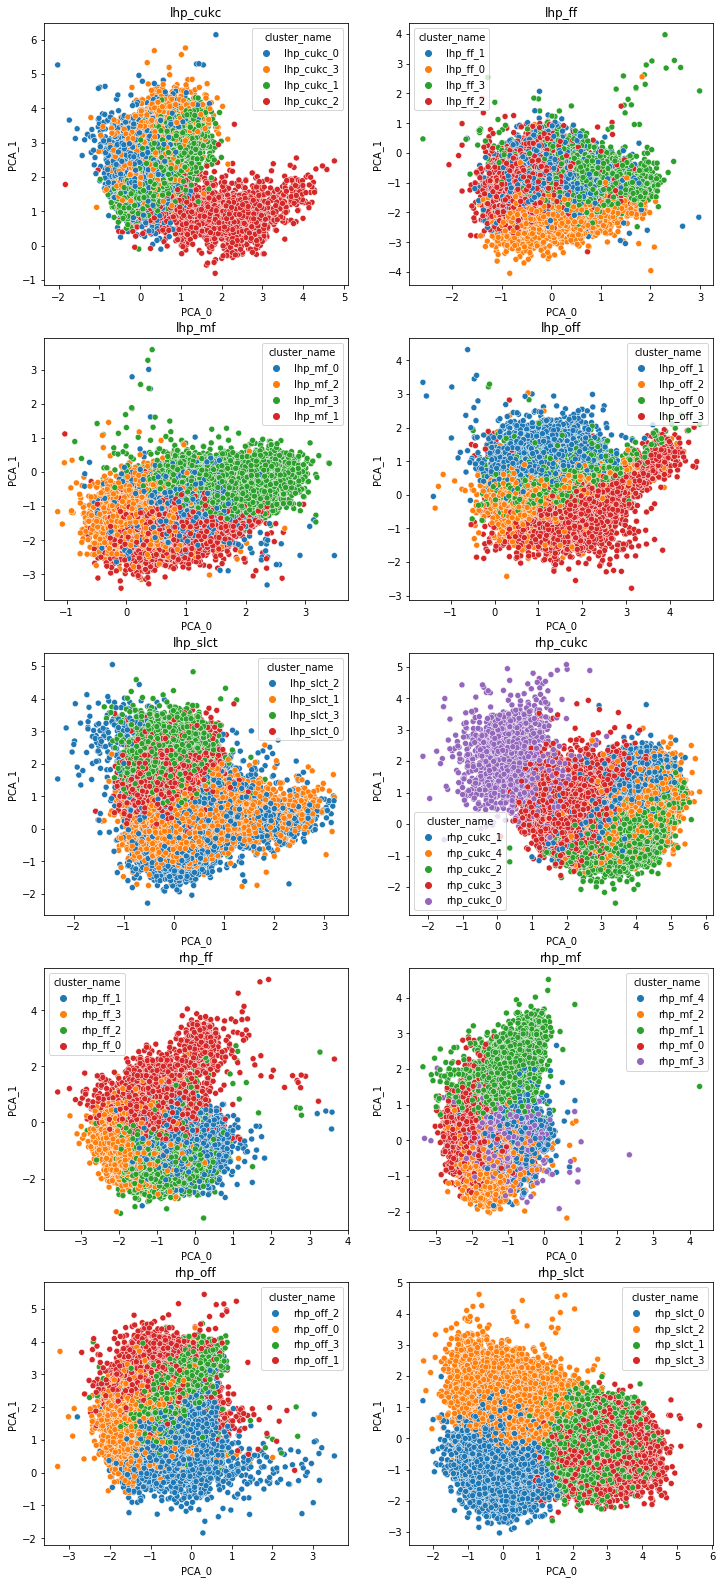

In [15]:
# visualize clusters in PCA space

count = 1
plt.subplots(figsize=(12, 28))

for i in dict_of_buckets:
    plt.subplot(5,2,count)
    sns.scatterplot(data=dict_of_buckets[i], x="PCA_0", y="PCA_1", hue="cluster_name")
    plt.title(i)
    count+=1

plt.show()